In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from capytaine_generator import CapytaineSlantSolver
from matplotlib.ticker import ScalarFormatter

try:
    from openflash import *
    from openflash.multi_equations import *
    from openflash.multi_constants import g
    print("OpenFLASH modules imported successfully!")
except ImportError as e:
    print(f"Error importing OpenFLASH modules. Error: {e}")

# Set NumPy print options for better readability
np.set_printoptions(threshold=np.inf, linewidth=np.inf, precision=8, suppress=True)

import sys
from pathlib import Path
HERE = Path.cwd().resolve()
store_path_prefix = str((HERE / "data").resolve())
store_path_str = store_path_prefix + "/slants.pkl"

low_m0_dir = (HERE / ".." / "dev" / "python" / "limiting-cases").resolve()
if str(low_m0_dir) not in sys.path:
    sys.path.insert(0, str(low_m0_dir))
from low_m0 import low_get_hydros

utils_path = (HERE / ".." / "sea-lab-utils").resolve()
utils_str = str(utils_path)
if utils_str not in sys.path:
    sys.path.insert(0, utils_str)
from pyplotutilities import colors
colors.get_colors()

figs_path_prefix = str((HERE / ".." / "pubs/JFM/figs").resolve())

import warnings
warnings.filterwarnings("ignore") # Inelegant, but gets rid of LinAlgWarnings


OpenFLASH modules imported successfully!


In [11]:
# Variable Definitions
h = 50.00 # sea depth [m]
d_list = [14.45, 14.45-7.32-5.08] # drafts [m]
a_list = [2.5/2, 8.4/2] # radii [m]
# h, d_list, a_list = 2, [1, 0.5], [0.5, 1]
minexp = -3
exponents = np.linspace(minexp, 3, 121)
omega_sweep = np.array(list(10**exponents)+ [np.inf])
low_omegas = np.array(list(10**np.linspace(minexp, 0, 61)))
low_m0s = [wavenumber(omega, h) for omega in low_omegas]
NMK = [100, 100, 100] # number of coefficients in each region
heaving = [1, 1]

In [12]:
# Regular MEEM
def get_MEEM_hydros(h, omega_sweep, d_list, a_list, NMK):
    A_MEEM = np.zeros_like(omega_sweep)
    B_MEEM = np.zeros_like(omega_sweep)

    body = SteppedBody(a=np.array(a_list), d=np.array(d_list), slant_angle= np.zeros_like(a_list), heaving=True)
    arrangement = ConcentricBodyGroup([body])
    geometry = BasicRegionGeometry(body_arrangement=arrangement, h=h, NMK=NMK)
    problem = MEEMProblem(geometry)
    problem.set_frequencies(omega_sweep)
    engine = MEEMEngine(problem_list=[problem])
    for j in range(len(omega_sweep)):
        m0 = wavenumber(omega_sweep[j], h)
        X = engine.solve_linear_system_multi(problem, m0)
        coeffs = engine.compute_hydrodynamic_coefficients(problem, X, m0)
        A_MEEM[j] = coeffs[0]['real']
        B_MEEM[j] = coeffs[0]['imag']

    return A_MEEM, B_MEEM

In [13]:
added_masses, radiation_dampings = get_MEEM_hydros(h, omega_sweep, d_list, a_list, NMK)
low_added_masses, low_radiation_dampings = low_get_hydros(h, d_list, a_list, heaving, low_m0s)

In [42]:
# Plot Settings
l_width = 3 # line width
m_size = 7 # marker size
lab_fs = 11 # x and y label font size
leg_fs = lab_fs * 0.9  # legend font size
fig_h = 6 # figure height
fig_w = 5 # figure width

In [31]:
css = CapytaineSlantSolver(False, False, False, False, False)

# Function for getting coordinates of WEC geometry
def get_scaled_geom(a_list, d_in, d_out):

    RHS_coords = css.get_points(a_list, d_in, d_out)
    x_coords, y_coords = map(np.array, zip(*RHS_coords))

    x_undeformed = np.concatenate([-x_coords[::-1], x_coords])
    y_undeformed = np.concatenate([y_coords[::-1], y_coords])

    
    return x_undeformed, y_undeformed

def plot_geom(ax, a_list, d_in, d_out, x0, x_width):
  x_undeformed, y_undeformed = get_scaled_geom(a_list, d_in, d_out)
  y_height = max(d_in)/(2 * a_list[-1]) * x_width
  y0 = 0.97 - y_height
  ax_ins = ax.inset_axes([x0, y0, x_width, y_height])
  ax_ins.fill(x_undeformed, y_undeformed, color=[0.7,0.7,0.7], edgecolor='black')
  ax_ins.set_aspect('equal')
  ax_ins.set_xticks([])
  ax_ins.set_yticks([])
  ax_ins.axis('off') 

In [45]:
def plot_hydros(omega_sweep, low_omegas, hydros, low_hydros, hydro_name):
  plt.figure(figsize = (6, 6))
  plt.plot(omega_sweep[:-1], hydros[:-1], label = ("MEEM"), color = "orange", zorder=1)
  plt.hlines(hydros[-1], omega_sweep[0], omega_sweep[-2], label = ("Infinite Frequency"), color = "green", linestyle = "--", zorder=2)
  plt.plot(low_omegas, low_hydros, label = ("Low Frequency Approximation"), color = "blue", linestyle = "--", zorder=3)
  plt.xscale('log', base = 10)
  plt.xlabel("frequency [rad/s]")
  plt.ylabel(hydro_name)
  plt.title(hydro_name + " at high frequencies")
  plt.legend()
  plt.show()

def standard_subplot(omega_sweep, low_omegas, hydros, low_hydros, ax):
  hydro_inf = hydros[-1]
  ax.plot(omega_sweep[:-1], hydros[:-1],
          linestyle='-', color=colors.green, label='Standard MEEM', 
          linewidth=l_width-1.5, zorder=2)
  ax.plot(low_omegas, low_hydros,
          linestyle='--', color=colors.orange, label=r'Low $\omega$ Approximation', 
          linewidth=l_width-1.5, zorder=3)
  ax.axhline(hydro_inf, linestyle="--", linewidth=l_width-1,
             color = colors.blue, label = r"$\omega = \infty$", zorder=1)
  
def plot_and_save_hydros(omega_sweep, low_omegas, ams, dps, low_ams, low_dps,
                         a_list, d_in, d_out):
  fig, ax = plt.subplots(2, 1, figsize=(fig_h, fig_w), sharex = True)
  for a in ax:
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1)) 
    a.yaxis.set_major_formatter(formatter)
  
  standard_subplot(omega_sweep, low_omegas, ams, low_ams, ax[0])
  standard_subplot(omega_sweep, low_omegas, dps, low_dps, ax[1])

  plot_geom(ax[1], a_list, d_in, d_out, 0.7, 0.35)

  ax[1].set_xlim([10**-3, 10**3])
  ax[0].set_ylim([0, 2.5e5])
  ax[1].set_ylim([-0.1e4, 5.5e4])
  # ax[1].set_ylim([3.9e4, 5.1e4])
  ax[0].legend(loc='upper right', fontsize=leg_fs, frameon=False)
  ax[1].set_xscale("log", base = 10)
  ax[1].set_xlabel('Frequency [rad/s]', fontsize=lab_fs)
  ax[0].set_ylabel('Added Mass [Ns/m]', fontsize=lab_fs)
  ax[1].set_ylabel('Damping [Ns/m]', fontsize=lab_fs)

  full_path = figs_path_prefix + "/MEEM-Low-Freq.pdf"
  fig.savefig(full_path, format='pdf', dpi=300, bbox_inches='tight')

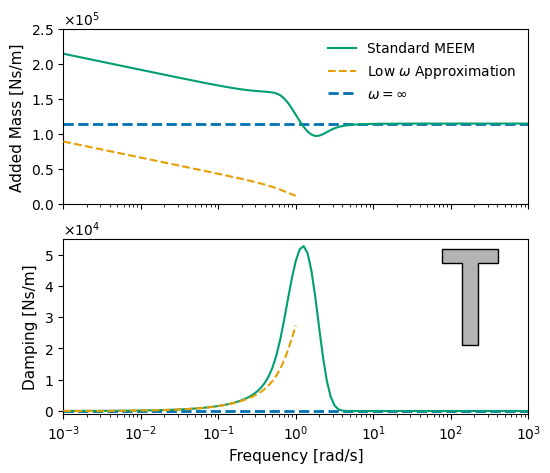

In [46]:
plot_and_save_hydros(omega_sweep, low_omegas,
                     added_masses, radiation_dampings,
                     low_added_masses, low_radiation_dampings,
                     a_list, d_list, d_list)

In [9]:
# startdex = 20
# plot_hydros(omega_sweep[startdex:], low_omegas[startdex:],
#             added_masses[startdex:], low_added_masses[startdex:], "Added Mass")
# plot_hydros(omega_sweep[startdex:], low_omegas[startdex:],
#             radiation_dampings[startdex:], low_radiation_dampings[startdex:], "Damping")

In [10]:
# # RM3
# h = 70
# d_list = [35, 3]
# a_list = [3, 10]
# heaving_list = [1, 0]
# nmk = 100
# exponents = np.linspace(-7, 3, 101)
# m0s = list(10**exponents) + [np.inf]

# def make_flat_geometry(h, d, a, heaving, NMK):
#   bodies = [SteppedBody(a=np.array([a[i]]), d=np.array([d[i]]), slant_angle=np.array([0.0]), heaving=heaving[i]) for i in range(len(a))]
#   return BasicRegionGeometry(body_arrangement=ConcentricBodyGroup(bodies), h=h, NMK=NMK)
  
# NMK = [nmk, nmk, nmk]
# frequencies = np.array([omega(m0, h, g) for m0 in m0s])
# problem = MEEMProblem(make_flat_geometry(h, d_list, a_list, heaving_list, NMK))
# problem.set_frequencies(frequencies)
# engine = MEEMEngine(problem_list=[problem])

# coeff_count = 5
# er1ns = [[] for _ in range(coeff_count)]
# added_masses = []
# radiation_dampings = []
# for m0 in m0s:
#   X = engine.solve_linear_system_multi(problem, m0)
#   hydros = engine.compute_hydrodynamic_coefficients(problem, X, m0)
#   added_masses.append(to_nondim(hydros[1]["real"], a_list, heaving_list))
#   radiation_dampings.append(to_nondim(hydros[1]["imag"], a_list, heaving_list))
#   Cs = engine.reformat_coeffs(X, NMK, len(NMK) - 1)
#   for i in range(coeff_count):
#     er1ns[i].append(Cs[2][i]) # Store first coeff_count R1 coeffs in e region
# er1ns_reals = [[np.real(entry) for entry in lst] for lst in er1ns]
# er1ns_imags = [[np.imag(entry) for entry in lst] for lst in er1ns]

# def plot_coeffs(m0s, float_coeffs, coeff_type):
#   cmap = colormaps.get_cmap("inferno") #gnuplot
#   colors = [cmap(1 - (0.1 + 0.8 * i / (coeff_count - 1))) for i in range(coeff_count)]
#   plt.figure(figsize = (6, 6))
#   for i in range(coeff_count):
#     ys = [entry/float_coeffs[i][0] for entry in float_coeffs[i]]
#     plt.plot(m0s, ys, label = fr'$C_{{{coeff_type}{i}}}^{{i_2}}$', color = colors[i])
#   plt.xscale('log', base = 10)
#   plt.xlabel("wavenumber")
#   plt.ylabel("ratio of coefficient value to its value at wavenumber = 0.01")
#   plt.legend()
#   plt.show()

# plot_coeffs(m0s, er1ns_reals, "1")
# plot_coeffs(m0s, er1ns_imags, "1")